# Cohort Project 2021: Rydberg Atoms; Task 3

This notebook provides a solution for the "Rydberg" project (week 2) for the CDL cohort project of 2021. See the original Github repositiory [here](https://github.com/CDL-Quantum/CohortProject_2021).

## Instructions
This notebook has been designed to be used in a google colab environment which runs jupyter notebooks

For this task we will be looking at three different solutions to the Gotham City problem. The first way is using the classical optimization method from Task 1. I have gone ahead and copied the code from Task 1 into this notebook, as that will be our starting point.

### Problem Statement
The City of Gotham is looking at putting in new cell phone towers. The possible locations of the
cell phone towers are given in Fig. 2. The billionaire Bruce Wayne is funding the project and he
loves his money. Therefore, Gotham should only purchase the required number of cell phone towers
such that 1) the cell phone tower signal ranges do not overlap7
, and 2) as much of Gotham City
can be within cell signal range

### 1. Explain why this is a problem that can be easily mapped to the UD-MIS problem.

A UD-MIS

In [2]:
import numpy as np
import scipy as sc
from scipy.sparse import linalg
import matplotlib.pyplot as plt
import networkx as nx
from abstract_udmis import AbstractUDMIS
import openfermion as of
import pandas as pd

%matplotlib inline

In [4]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

In [5]:
# Functions for drawing Graphs

def draw_graph_state(graph,occupations, ax):
    G = nx.from_numpy_array(graph.edges)
    graph_np = np.array(graph.graph)
    x_vals = graph_np[:,0]
    y_vals = graph_np[:,1]

    colormap = []
    for x,y,occ in zip(x_vals,y_vals,occupations):
        color = 'red' if occ else 'black'
        colormap.append(color)
        circle = plt.Circle((x,y), 0.5, color='gray', alpha=0.1)
        ax.add_patch(circle)

    nx.draw(G, pos=graph.graph, node_color=colormap, edge_color='b',ax=ax)
    ax.axis('equal')

In [6]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)        

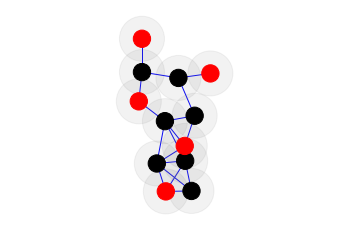

In [33]:
u = 1.35
graph = [(1.19, 4.25),(2.71, 3.48),
         (1.19, 3.51),(2, 3.38),
         (1.12, 2.86),(1.70, 2.42),
         (2.36, 2.54),(1.52, 1.48),
         (2.15, 1.54),(2.14, 1.87),
         (1.72, 0.86),(2.29, 0.87),
        ]

udmis = UDMIS(u, graph)
N=20000
T_i = 100
T_f = 0.000001
t = np.arange(N+1)
T = T_i * ((T_f/T_i) ** (t/N))
x = []
y = []
occupations = []
for t in range(N):
    temp = T[t]
    E = udmis.mc_step(T=temp)
    bitstring = ""
    for i in udmis.occupations:
        bitstring +=str(int(i))
        occupations.append(bitstring)
    if t%100 == 0:
        x.append(t)
        y.append(E)
fig, ax = plt.subplots()
draw_graph_state(udmis, udmis.occupations, ax)

Text(0.5, 1.0, 'T$_{f}$ = $10^{-6}$ K')

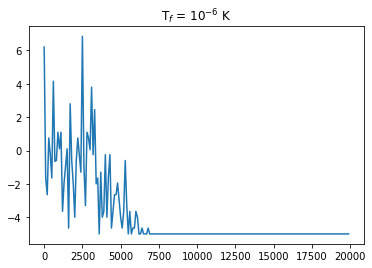

In [34]:
figure, axis = plt.subplots()
axis.plot(x,y)
axis.set_title("T$_{f}$ = $10^{-6}$ K")

In [35]:
print(f'The energy is : {y[-1]}')
print(udmis.occupations)

The energy is : -5.0
[ True  True False False  True False False False False  True  True False]


Plotting a histogram of states

In [37]:
o_df = pd.Series(occupations)
oc_top_df = o_df.value_counts()[o_df.value_counts()> 200]
oc_top_df.name = 'Occupations'
oc_top_df

1              17312
11             14689
110            14065
1100           13583
11001          13284
               ...  
11001010100      234
1011             231
110110           227
1111             212
10010            207
Name: Occupations, Length: 67, dtype: int64

Text(0.5, 1.0, 'Distribution Plot')

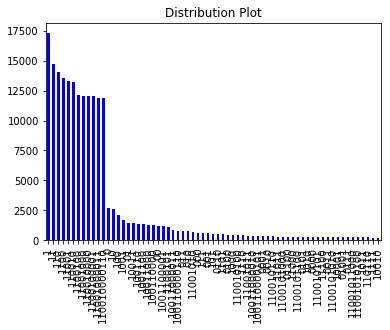

In [39]:
fig = oc_top_df.plot(kind='bar', color='b')
fig.set_title('Distribution Plot')